In [50]:
# importing the bare necessities as of now to begin with
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import PIL.Image
import matplotlib.pyplot as plt
import keras

### Lets quickly check whats inthose project folders, how the image looks like

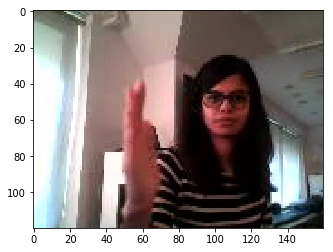

In [4]:
img = PIL.Image.open(
    '/mnt/disks/user/project/PROJECT/Project_data/train/WIN_20180925_17_54_25_Pro_Left_Swipe_new/WIN_20180925_17_54_25_Pro_00010.png')
plt.imshow(img)

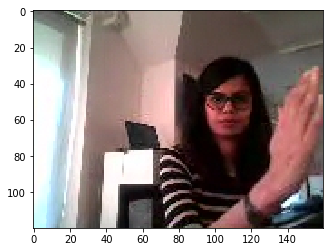

In [5]:
img = PIL.Image.open(
    '/mnt/disks/user/project/PROJECT/Project_data/train/WIN_20180925_17_54_25_Pro_Left_Swipe_new/WIN_20180925_17_54_25_Pro_00039.png')
plt.imshow(img)

This is so cool and exciting! Lets get started

We set the random seed so that the results don't vary drastically.

Lets also use tensorFlow backend

In [6]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())
batch_size = 10

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [21]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3))  
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(120,120))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [22]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choosing 10 epochs after experimenting with the batchsize
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [23]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#Write your model here

#Starting Model_one

model_one = Sequential()

#starting wtih 8 filters
model_one.add(Conv3D(8, # starting with 8 filters
                 kernel_size=(3,3,3), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_one.add(BatchNormalization())
model_one.add(Activation('relu'))

model_one.add(MaxPooling3D(pool_size=(2,2,2)))

#choosing 16 filters
model_one.add(Conv3D(16, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_one.add(BatchNormalization())
model_one.add(Activation('relu'))

model_one.add(MaxPooling3D(pool_size=(2,2,2)))

#choosing 32 filters
model_one.add(Conv3D(32,
                 kernel_size=(1,3,3), 
                 padding='same'))
model_one.add(BatchNormalization())
model_one.add(Activation('relu'))

model_one.add(MaxPooling3D(pool_size=(2,2,2)))

model_one.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_one.add(BatchNormalization())
model_one.add(Activation('relu'))

model_one.add(MaxPooling3D(pool_size=(2,2,2)))

#Layer being flattened using flatten()
model_one.add(Flatten())

model_one.add(Dense(1000, activation='relu'))
model_one.add(Dropout(0.5))

model_one.add(Dense(500, activation='relu'))
model_one.add(Dropout(0.5))

#softmax layer
model_one.add(Dense(5, activation='softmax'))


Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

In [24]:
optimiser = optimizers.Adam(lr=0.001) # Writing our optimizer, using Adam with lr of 0.001
model_one.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_one.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_9 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 15, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 15, 60, 60, 16)    0         
__________

### Adam optimizer
Adam: Adaptive moment estimation

Adam = RMSprop + Momentum

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [25]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [26]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [27]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [13]:
model_one.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 8.9941 - categorical_accuracy: 0.2769Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 85s 1s/step - loss: 8.9825 - categorical_accuracy: 0.2717 - val_loss: 12.1857 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-04-1813_41_01.845957/model-00001-9.00369-0.27451-12.18567-0.23000.h5
Epoch 2/10
67/67 [==============================] - 24s 361ms/step - loss: 7.7663 - categorical_accuracy: 0.2438 - val_loss: 5.8493 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model_init_2020-04-1813_41_01.845957/model-00002-7.76633-0.24378-5.84930-0.29000.h5
Epoch 3/10
67/67 [==============================] - 26s 395ms/step - loss: 3.9425 - categorical_accuracy: 0.3085 - val_loss: 2.0598 - val_categorical_accuracy: 0.3500

Epoch 00003: saving model to model_init_2020-04-1813_41_01.845957/model-00003-3.94254-0.30846-2.05982-0.35000.h5
Epoch 4/10
67/67 [==============================] - 26s 390ms/step - loss: 2.0603 - categorical_accuracy: 0.3134 - val_loss: 1.3462 - val_categorical_accuracy: 0.4200

E

OKay phew that looks like it went well. Now lets check for other classes that are there

In [28]:
classes = 5 #left swipe, right swipe, thumbs up, thumbs down, stop
channel = 3
x = 30 # Taking 30 number of frames
y = 120 # keeping the same width
z = 120 # And yes the same height

# same generator function 

def generator_ex(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    batch_data[folder,idx] = temp #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            #setting up RGB batch data and channel
            batch_data = np.zeros((batch_size,x,y,z,channel)) 
            #defining one hot output of batch labels
            batch_labels = np.zeros((batch_size,classes)) 
            #this loop will help go over eaach batch size
            for folder in range(batch_size): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                  
                    temp = imresize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = temp
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

### Second Model

In [29]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# Creating second model
model_two = Sequential()
model_two.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same'))
model_two.add(Activation('relu'))
model_two.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_two.add(Dropout(0.25))

model_two.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_two.add(Dropout(0.25))

model_two.add(Flatten())
model_two.add(Dense(512, activation='relu'))
model_two.add(Dropout(0.5))
model_two.add(Dense(classes, activation='softmax'))

model_two.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_two.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 30, 120, 120, 32)  2624      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 30, 120, 120, 32)  27680     
_________________________________________________________________
activation_14 (Activation)   (None, 30, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 10, 40, 40, 32)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 40, 40, 32)    0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 10, 40, 40, 64)    55360     
__________

In [30]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [31]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/10
 /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 7s - loss: 1.7687 - categorical_accuracy: 0.2000 Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 251s 4s/step - loss: 1.7621 - categorical_accuracy: 0.2020 - val_loss: 1.5242 - val_categorical_accuracy: 0.3700

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-1.76517-0.20060-1.52415-0.37000.h5
Epoch 2/10
67/67 [==============================] - 47s 703ms/step - loss: 1.5303 - categorical_accuracy: 0.3383 - val_loss: 1.3000 - val_categorical_accuracy: 0.4900

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-1.53026-0.33831-1.30003-0.49000.h5
Epoch 3/10
67/67 [==============================] - 47s 702ms/step - loss: 1.5030 - categorical_accuracy: 0.3085 - val_loss: 1.3793 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-1.50303-0.30846-1.37934-0.46000.h5
Epoch 4/10
67/67 [==============================] - 47s 702ms/step - loss: 1.3241 - categorical_accuracy: 0.4229 - val_loss: 1.2173 - val_categorical_accuracy: 0.5800

Ep

## Experiment 1: 
### Now lets try this same model but with new values for frames, height and width

In [35]:
x = 30 
y = 60 
z = 60 
#the number of frames should be in line with the height and width.

In [36]:
# Define model with new values

# Creating second model
model_two = Sequential()
model_two.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(x,y,z,channel), padding='same')) #passing new values
model_two.add(Activation('relu'))
model_two.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_two.add(Dropout(0.25))

model_two.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_two.add(Activation('relu'))
model_two.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model_two.add(Dropout(0.25))

model_two.add(Flatten())
model_two.add(Dense(512, activation='relu'))
model_two.add(Dropout(0.5))
model_two.add(Dense(classes, activation='softmax'))

model_two.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_two.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_21 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_22 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 10, 20, 20, 64)    55360     
__________

In [37]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [38]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


65/67 [============================>.] - ETA: 2s - loss: 1.6440 - categorical_accuracy: 0.1985Batch:  67 Index: 10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 73s 1s/step - loss: 1.6431 - categorical_accuracy: 0.1975 - val_loss: 1.5882 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-1.64428-0.19608-1.58815-0.23000.h5
Epoch 2/10
67/67 [==============================] - 23s 337ms/step - loss: 1.6151 - categorical_accuracy: 0.2388 - val_loss: 1.5910 - val_categorical_accuracy: 0.3000

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-1.61512-0.23881-1.59104-0.30000.h5
Epoch 3/10
67/67 [==============================] - 24s 357ms/step - loss: 1.5756 - categorical_accuracy: 0.2687 - val_loss: 1.5104 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-1.57564-0.26866-1.51043-0.37000.h5
Epoch 4/10
67/67 [==============================] - 25s 372ms/step - loss: 1.4609 - categorical_accuracy: 0.3333 - val_loss: 1.4065 - val_categorical_accuracy: 0.4300

Epo

### With 30 

In [39]:
## what happens with 30 batches
train_generator = generator_ex(train_path, train_doc, 30)
val_generator = generator_ex(val_path, val_doc, 30)

In [40]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 30
Epoch 1/10
30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/67 [>.............................] - ETA: 4:31 - loss: 1.1783 - categorical_accuracy: 0.5667Batch:  4 Index: 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 88s 1s/step - loss: 1.1097 - categorical_accuracy: 0.4965 - val_loss: 1.2045 - val_categorical_accuracy: 0.5125

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-1.10997-0.52956-1.20448-0.51250.h5
Epoch 2/10
67/67 [==============================] - 24s 358ms/step - loss: 1.1143 - categorical_accuracy: 0.5423 - val_loss: 1.1796 - val_categorical_accuracy: 0.5700

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-1.11430-0.54229-1.17963-0.57000.h5
Epoch 3/10
67/67 [==============================] - 24s 351ms/step - loss: 1.1299 - categorical_accuracy: 0.5124 - val_loss: 1.2220 - val_categorical_accuracy: 0.5700

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-1.12988-0.51244-1.22196-0.57000.h5
Epoch 4/10
67/67 [==============================] - 24s 354ms/step - loss: 1.0425 - categorical_accuracy: 0.5821 - val_loss: 1.1658 - val_categorical_accuracy: 0.5300

Epo

reducing learning rate to 7.8

## Experiment 2

In [41]:
## Lets try with a new batch of 20 
train_generator = generator_ex(train_path, train_doc, 20)
val_generator = generator_ex(val_path, val_doc, 20)

In [48]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


32/67 [=============>................] - ETA: 1:20 - loss: 1.6094 - categorical_accuracy: 0.2266Batch:  34 Index: 20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 88s 1s/step - loss: 1.6106 - categorical_accuracy: 0.2173 - val_loss: 1.6078 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-04-1813_41_01.845957/model-00001-1.60958-0.22572-1.60779-0.21000.h5
Epoch 2/10
67/67 [==============================] - 29s 431ms/step - loss: 1.6061 - categorical_accuracy: 0.1990 - val_loss: 1.6076 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2020-04-1813_41_01.845957/model-00002-1.60612-0.19900-1.60761-0.21000.h5
Epoch 3/10
67/67 [==============================] - 30s 454ms/step - loss: 1.6128 - categorical_accuracy: 0.1791 - val_loss: 1.6077 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-04-1813_41_01.845957/model-00003-1.61277-0.17910-1.60767-0.21000.h5
Epoch 4/10
67/67 [==============================] - 30s 447ms/step - loss: 1.6058 - categorical_accuracy: 0.2289 - val_loss: 1.6077 - val_categorical_accuracy: 0.2100

Epo

### Experiment 3
#### Now trying for a batch of 40

In [42]:
train_generator = generator_ex(train_path, train_doc, 40)
val_generator = generator_ex(val_path, val_doc, 40)

In [43]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 40
Source path =  Epoch 1/10
/mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/67 [..............................] - ETA: 11:53 - loss: 0.7548 - categorical_accuracy: 0.7500Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 188s 3s/step - loss: 0.7168 - categorical_accuracy: 0.7202 - val_loss: 1.1581 - val_categorical_accuracy: 0.5625

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-0.71992-0.71594-1.15806-0.56250.h5
Epoch 2/10
67/67 [==============================] - 122s 2s/step - loss: 0.6652 - categorical_accuracy: 0.7305 - val_loss: 1.1230 - val_categorical_accuracy: 0.5200

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-0.66507-0.73133-1.12305-0.52000.h5
Epoch 3/10
67/67 [==============================] - 123s 2s/step - loss: 0.6277 - categorical_accuracy: 0.7515 - val_loss: 1.0361 - val_categorical_accuracy: 0.5650

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-0.62769-0.75154-1.03608-0.56500.h5
Epoch 4/10
67/67 [==============================] - 123s 2s/step - loss: 0.6074 - categorical_accuracy: 0.7594 - val_loss: 1.2294 - val_categorical_accuracy: 0.5100

Epoch 00

#### At this point we are getting about 84.4% accuracy 

## There are a few  optimization methods that we can use

### Adagrad
It makes big updates for infrequent parameters and small updates for frequent parameters. For this reason, it is well-suited for dealing with sparse data.

The main benefit of Adagrad is that we don’t need to tune the learning rate manually. Most implementations use a default value of 0.01 and leave it at that.

#### Disadvantage —

Its main weakness is that its learning rate is always Decreasing and decaying.

 

### AdaDelta
It is an extension of AdaGrad which tends to remove the decaying learning Rate problem of it.

Another thing with AdaDelta is that we don’t even need to set a default learning rate.

# Experiment 4
Changing batchsize to 30 and trying

In [44]:
train_generator = generator_ex(train_path, train_doc, 30)
val_generator = generator_ex(val_path, val_doc, 30)

In [45]:
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 30
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train Epoch 1/10
; batch size = 30


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 3/67 [>.............................] - ETA: 4:36 - loss: 0.3320 - categorical_accuracy: 0.8889

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 87s 1s/step - loss: 0.4888 - categorical_accuracy: 0.8198 - val_loss: 1.2181 - val_categorical_accuracy: 0.5875

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-0.43908-0.84906-1.21814-0.58750.h5
Epoch 2/10
67/67 [==============================] - 24s 363ms/step - loss: 0.4427 - categorical_accuracy: 0.8159 - val_loss: 1.2694 - val_categorical_accuracy: 0.5500

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-0.44271-0.81592-1.26937-0.55000.h5
Epoch 3/10
67/67 [==============================] - 23s 341ms/step - loss: 0.4137 - categorical_accuracy: 0.8607 - val_loss: 1.2295 - val_categorical_accuracy: 0.5900

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-0.41368-0.86070-1.22953-0.59000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 4/10
67/67 [==============================] - 24s 361ms/step - loss: 0.3720 - catego

#### The accuracy improved to ~90% now! Lets try with next experiment 

### Experiment 5 
Checking with more epocs also with AdaDelta optimizer

In [51]:
new_epochs = 20 # choose the number of epochs
print ('# epochs =', new_epochs)


# epochs = 20


In [52]:
model_two.compile(optimizer=keras.optimizers.Adadelta(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model_two.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_21 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_22 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 10, 20, 20, 64)    55360     
__________

In [53]:
# lets try this now tih 40 batchsize
train_generator = generator_ex(train_path, train_doc, 40)
val_generator = generator_ex(val_path, val_doc, 40)
model_two.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 40
Epoch 1/10
 /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 2/67 [..............................] - ETA: 6:16 - loss: 0.4026 - categorical_accuracy: 0.8375Batch:  3 Index: 40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 186s 3s/step - loss: 0.5412 - categorical_accuracy: 0.7914 - val_loss: 1.1270 - val_categorical_accuracy: 0.5875

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-0.54490-0.78957-1.12698-0.58750.h5
Epoch 2/10
67/67 [==============================] - 123s 2s/step - loss: 0.3828 - categorical_accuracy: 0.8672 - val_loss: 1.5712 - val_categorical_accuracy: 0.5550

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-0.38344-0.86695-1.57117-0.55500.h5
Epoch 3/10
67/67 [==============================] - 121s 2s/step - loss: 0.2906 - categorical_accuracy: 0.8876 - val_loss: 1.3825 - val_categorical_accuracy: 0.6400

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-0.29061-0.88762-1.38246-0.64000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.5.
Epoch 4/10
67/67 [==============================] - 118s 2s/step - loss: 0.1825 - categorical_accuracy: 0.9342 

### As of here as you can see we are getting 97% accuracy. Lets go ahead with the final model

## Final Model

In [61]:
nb_filters = [8,16,32,64]
nb_dense = [256, 128, 5]

# Input
input_shape=(30,120,120,3)


model_final = Sequential()

model_final.add(Conv3D(nb_filters[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(BatchNormalization())
model_final.add(Activation('relu'))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))

model_final.add(Conv3D(nb_filters[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_final.add(Activation('relu'))
model_final.add(Dropout(0.25))

model_final.add(MaxPooling3D(pool_size=(2,2,2)))


model_final.add(Flatten())

model_final.add(Dense(nb_dense[0], activation='relu'))
model_final.add(Dropout(0.5))

model_final.add(Dense(nb_dense[1], activation='relu'))
model_final.add(Dropout(0.5))


model_final.add(Dense(nb_dense[2], activation='softmax'))


In [66]:
optimiser = keras.optimizers.Adam() #write your optimizer
final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 30, 60, 60, 8)     656       
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 60, 60, 8)     32        
_________________________________________________________________
activation_29 (Activation)   (None, 30, 60, 60, 8)     0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 15, 30, 30, 8)     0         
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 15, 30, 30, 16)    3472      
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 30, 30, 16)    64        
_________________________________________________________________
activation_30 (Activation)   (None, 15, 30, 30, 16)    0         
__________

In [67]:
train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)

In [68]:
batch_size = 10
num_epochs = 20
final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/trainEpoch 1/20 ; batch size = 10



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


66/67 [============================>.] - ETA: 1s - loss: 1.7568 - categorical_accuracy: 0.2864

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 71s 1s/step - loss: 1.7518 - categorical_accuracy: 0.2821 - val_loss: 1.4544 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-1.75525-0.28507-1.45438-0.30000.h5
Epoch 2/20
67/67 [==============================] - 22s 324ms/step - loss: 1.5217 - categorical_accuracy: 0.3333 - val_loss: 1.4445 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-1.52174-0.33333-1.44455-0.35000.h5
Epoch 3/20
67/67 [==============================] - 23s 350ms/step - loss: 1.6042 - categorical_accuracy: 0.2985 - val_loss: 1.3833 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-1.60415-0.29851-1.38335-0.44000.h5
Epoch 4/20
67/67 [==============================] - 22s 332ms/step - loss: 1.4999 - categorical_accuracy: 0.2985 - val_loss: 1.3577 - val_categorical_accuracy: 0.4700

Epo

Accuracy can be improved

In [71]:
#trying with a higher batchsize 
batch_size = 64
num_epochs = 20

train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)


final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 64
Epoch 1/20
 ; batch size = 64


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 1/67 [..............................] - ETA: 9:02 - loss: 0.8348 - categorical_accuracy: 0.6719Batch:  2 Index: 64


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


67/67 [==============================] - 193s 3s/step - loss: 0.8858 - categorical_accuracy: 0.6166 - val_loss: 0.8173 - val_categorical_accuracy: 0.6930

Epoch 00001: saving model to model_init_2020-04-1815_27_20.054022/model-00001-0.89415-0.61555-0.81732-0.69304.h5
Epoch 2/20
67/67 [==============================] - 117s 2s/step - loss: 0.8049 - categorical_accuracy: 0.6618 - val_loss: 0.8443 - val_categorical_accuracy: 0.7100

Epoch 00002: saving model to model_init_2020-04-1815_27_20.054022/model-00002-0.80498-0.66175-0.84428-0.71000.h5
Epoch 3/20
67/67 [==============================] - 116s 2s/step - loss: 0.7671 - categorical_accuracy: 0.6576 - val_loss: 0.6717 - val_categorical_accuracy: 0.8000

Epoch 00003: saving model to model_init_2020-04-1815_27_20.054022/model-00003-0.76715-0.65759-0.67169-0.80000.h5
Epoch 4/20
67/67 [==============================] - 115s 2s/step - loss: 0.7426 - categorical_accuracy: 0.6910 - val_loss: 0.8625 - val_categorical_accuracy: 0.7250

Epoch 00

In [ ]:
#changing batchsize to 40....
batch_size = 40
num_epochs = 20

train_generator = generator_ex(train_path, train_doc, batch_size)
val_generator = generator_ex(val_path, val_doc, batch_size)


model_final.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)